In [1]:
#libraries

import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
%matplotlib inline
sns.set_style('whitegrid')

## Functions

In [2]:
#player profile

def get_player_profile(player_id):
    player_link = f'https://api.opendota.com/api/players/{player_id}'
    r = requests.get(player_link)
    player_df = pd.DataFrame(json.loads(r.text))
    
    return player_df

In [3]:
#players matches stats

def get_player_matches(player_id):
    
    matches_link = f'https://api.opendota.com/api/players/{player_id}/matches?significant=0'
    r = requests.get(matches_link)
    matches_df = pd.DataFrame(json.loads(r.text))
    
    return matches_df

In [4]:
#decoding heroes by hero_id

def get_heroes():
    
    heroes_link = f'https://api.opendota.com/api/heroStats'
    r = requests.get(heroes_link)
    heroes_df = pd.DataFrame(json.loads(r.text))
    return heroes_df

In [5]:
#players heroes

def get_player_heroes(player_id):
    
    player_heroes_link = f'https://api.opendota.com/api/players/{player_id}/heroes'
    r = requests.get(player_heroes_link)
    player_heroes_df = pd.DataFrame(json.loads(r.text))
    
    return player_heroes_df

In [6]:
#player peers

def get_player_peers(player_id):
    
    player_peers = f'https://api.opendota.com/api/players/{player_id}/peers'
    r = requests.get(player_peers)
    player_peers_df = pd.DataFrame(json.loads(r.text))
    
    return player_peers_df

In [7]:
#word cloud

def get_word_cloud(player_id):
    
    word_cloud = f'https://api.opendota.com/api/players/{player_id}/wordcloud'
    r = requests.get(word_cloud)
    word_cloud_df = pd.DataFrame(json.loads(r.text))
    
    return word_cloud_df

In [8]:
#convert unix match date

def unix_time_converter(ts):
    
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [9]:
#convert match duration into proper format

def duration_converter(duration):
    
    sec = duration
    ty_res = time.gmtime(sec)
    res = time.strftime("%H:%M:%S", ty_res)
    
    return res

## Get player info and create data frames

In [ ]:
player_id = str(input())

In [11]:
heroes_df = get_heroes()
player_df = get_player_profile(player_id)
player_matches_df = get_player_matches(player_id)
player_heroes_df = get_player_heroes(player_id)
player_peers_df = get_player_peers(player_id)
word_cloud_df = get_word_cloud(player_id)

## Cleaning

In [17]:
#remove some columns

player_matches_df.drop(['lobby_type', 
                        'version', 
                        'party_size', 
                        'leaver_status'], axis=1, inplace=True)

In [18]:
#convert 'player_slot' into Radiant/Dire

player_matches_df['player_slot'] = player_matches_df['player_slot'].apply(lambda x: 'Radiant' if x < 128 else 'Dire')

In [19]:
#winner side istead of True/False Radiant win

player_matches_df['radiant_win'] = player_matches_df['radiant_win'].apply(lambda x: 'Radiant' if x == True else 'Dire')

In [20]:
#convert duration into proper format

player_matches_df['duration'] = player_matches_df['duration'].fillna(0)
player_matches_df['duration'] = player_matches_df['duration'].apply(duration_converter)

In [21]:
#convert match date into proper format
player_matches_df['start_time'] = player_matches_df['start_time'].fillna(0)
player_matches_df['start_time'] = player_matches_df['start_time'].apply(unix_time_converter)

In [22]:
#decoding heroes names

player_matches_df['hero_id'] = player_matches_df['hero_id'].map(heroes_df.set_index('id')['localized_name'])

In [23]:
#mapping skill levels

skill_lvl = {1.0: 'Normal', 
             2.0: 'High', 
             3.0: 'Very high'}

player_matches_df['skill'] = player_matches_df['skill'].map(skill_lvl)
player_matches_df['skill'].fillna('N/A', inplace=True)

In [24]:
player_matches_df.head(3)

,match_id,player_slot,radiant_win,hero_id,start_time,duration,game_mode,kills,deaths,assists,skill
0,5889544250,Dire,Dire,Ancient Apparition,2021-03-15 23:13:42,00:42:51,22,3,7,19,Normal
1,5887724550,Dire,Dire,Templar Assassin,2021-03-14 22:47:54,00:23:29,23,11,3,8,Normal
2,5887702596,Dire,Dire,Templar Assassin,2021-03-14 22:20:58,00:19:57,23,8,2,9,Normal


In [25]:
#renameing columns

renamed_col = ['Match ID', 'Side', 'Winner', 'Hero', 'Match date', 'Duration', 'Game mode', 
               'Kills', 'Deaths', 'Assists', 'Skill level']

player_matches_df.columns = renamed_col

In [26]:
#creating 'Result' column

player_matches_df['Result'] = player_matches_df['Side'] == player_matches_df['Winner']

player_matches_df['Result'] = player_matches_df['Result'].apply(lambda x: 'Win' if x == True else 'Loss')

## Game modes names

In [27]:
#reading in game modes json

game_modes = pd.read_json('game_mode.json')

In [28]:
game_modes = game_modes.transpose()

In [29]:
game_modes.set_index('id', inplace=True)

In [30]:
game_modes.drop('balanced', axis=1, inplace=True)

In [31]:
#cleaning match modes names

def game_mode_cleaner(mode):
    
    mode = mode[10:]
    mode = mode.replace("_", " ")
    
    return mode

In [32]:
game_modes['name'] = game_modes['name'].apply(game_mode_cleaner)

In [33]:
game_modes

,name
id,
0,unknown
1,all pick
2,captains mode
3,random draft
4,single draft
5,all random
6,intro
7,diretide
8,reverse captains mode


In [34]:
#decoding game modes names

player_matches_df['Game mode'] = player_matches_df['Game mode'].replace(game_modes['name'])

In [35]:
player_matches_df.sample(10)

,Match ID,Side,Winner,Hero,Match date,Duration,Game mode,Kills,Deaths,Assists,Skill level,Result
1014,2023819112,Radiant,Dire,Silencer,2015-12-23 14:33:05,01:01:10,all pick,9,14,15,N/A,Loss
744,2697678704,Dire,Radiant,Silencer,2016-10-08 22:34:05,01:06:20,all pick,5,11,31,N/A,Loss
1084,1867041302,Dire,Dire,Lion,2015-10-14 23:12:23,00:50:19,all pick,1,15,9,N/A,Win
955,2281355827,Dire,Dire,Clinkz,2016-04-08 18:04:30,00:47:51,all pick,13,8,31,N/A,Win
316,3713330963,Dire,Radiant,Rubick,2018-02-02 16:44:57,00:51:05,all draft,1,8,12,N/A,Loss
95,5776697202,Radiant,Dire,Witch Doctor,2021-01-07 22:46:08,00:21:02,turbo,5,13,6,Normal,Loss
23,5857767266,Radiant,Dire,Shadow Shaman,2021-02-26 23:44:02,00:36:24,all draft,1,10,7,Normal,Loss
172,4436985148,Dire,Radiant,Rubick,2019-02-19 00:25:26,00:30:06,all draft,2,9,15,Normal,Loss
527,2980411304,Radiant,Radiant,Axe,2017-02-06 11:29:03,00:28:56,event,0,1,0,N/A,Win
305,3716618420,Radiant,Radiant,Vengeful Spirit,2018-02-04 10:00:48,00:42:32,all draft,3,13,19,Normal,Win


## PLAYER HEROES DF

In [36]:
player_heroes_df.head()

,hero_id,last_played,games,win,with_games,with_win,against_games,against_win
0,20,1613169130,132,72,29,13,49,27
1,48,1607208117,95,58,54,21,64,32
2,25,1610575025,88,39,52,18,66,43
3,75,1606434245,69,37,42,22,51,25
4,86,1615066718,55,25,40,16,54,29


In [37]:
player_heroes_df['hero_id'] = player_heroes_df['hero_id'].astype(int)

In [38]:
player_heroes_df['hero_id'] = player_heroes_df['hero_id'].map(heroes_df.set_index('id')['localized_name'])

In [39]:
player_heroes_df.drop('last_played', axis=1, inplace=True)

In [40]:
player_heroes_df.columns = ['Hero', 'Games', 'Win', 'Games with', 'Wins with', 'Games against', 'Wins against']

In [41]:
player_heroes_df['Win %'] = np.round((player_heroes_df['Win'] / player_heroes_df['Games'])*100, 1)
player_heroes_df['Win against %'] = np.round((player_heroes_df['Wins against'] / player_heroes_df['Games against'])*100, 1)

In [42]:
player_heroes_df.columns = [['Hero', 'Games', 'Win', 'Games with', 'Wins with', 'Games against',
       'Wins against', 'Win %', 'Win against %']]

In [43]:
player_heroes_cols = list(player_heroes_df.columns.values)

In [44]:
player_heroes_cols.insert(3, player_heroes_cols.pop(-2))

In [45]:
player_heroes_df = player_heroes_df[player_heroes_cols]

In [46]:
player_heroes_df.head()

,Hero,Games,Win,Win %,Games with,Wins with,Games against,Wins against,Win against %
0,Vengeful Spirit,132,72,54.5,29,13,49,27,55.1
1,Luna,95,58,61.1,54,21,64,32,50.0
2,Lina,88,39,44.3,52,18,66,43,65.2
3,Silencer,69,37,53.6,42,22,51,25,49.0
4,Rubick,55,25,45.5,40,16,54,29,53.7


## PLAYER PEERS

In [47]:
player_peers_df.head()

,account_id,last_played,win,games,with_win,with_games,against_win,against_games,with_gpm_sum,with_xpm_sum,personaname,name,is_contributor,last_login,avatar,avatarfull
0,198895394,1508711044,17,31,17,31,0,0,10787,12948,Bul Polkomtel Nuk,None,False,None,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...
1,38781228,1481755705,13,25,13,25,0,0,8962,10639,Muszroom,None,False,None,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...
2,117235565,1508711044,3,9,3,9,0,0,2999,3744,✪Muszroom,None,False,None,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...
3,194911709,1481413594,4,6,4,6,0,0,2130,2443,LeśnyOrzeł,None,False,None,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...
4,130121461,1494107220,0,5,0,5,0,0,1475,2018,Zbeer,None,False,None,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...


In [58]:
#top 3 friends

player_peers_df.sort_values(by='with_games', ascending=False).loc[:3,['personaname', 'with_games']]

,personaname,with_games
0,Bul Polkomtel Nuk,31
1,Muszroom,25
2,✪Muszroom,9
3,LeśnyOrzeł,6


In [59]:
#top 3 winning friends

player_peers_df.sort_values(by='with_win', ascending=False).loc[:3,['personaname', 'with_win']]

,personaname,with_win
0,Bul Polkomtel Nuk,17
1,Muszroom,13
3,LeśnyOrzeł,4


## WordCloud

In [60]:
word_cloud_df.drop('all_word_counts', axis=1, inplace=True)

In [61]:
word_cloud_df.dropna(inplace=True)

In [62]:
word_cloud_df['my_word_counts'] = word_cloud_df['my_word_counts'].astype(int)

In [63]:
words = []

for x in range(len(word_cloud_df + 1)):
    words.append((word_cloud_df.index[x] + " ") * word_cloud_df['my_word_counts'][x])

In [64]:
logo = np.array(Image.open("dota_logo.png"))

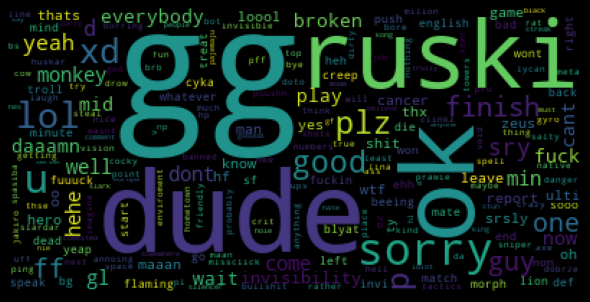

In [69]:
text = words
wordcloud = WordCloud(
    background_color = 'black',
    stopwords = STOPWORDS, max_words=300, collocations=False).generate(str(text))
fig = plt.figure(
    figsize = (8, 6),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

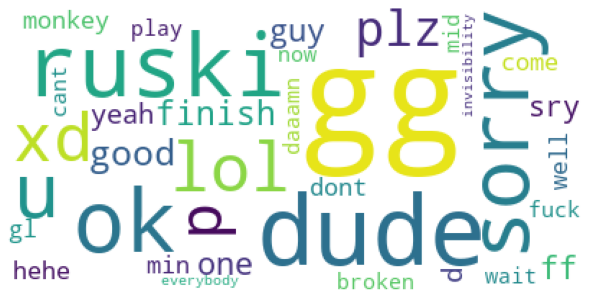

In [70]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
comment_words = ' '.join(words).lower()
  
wordcloud = WordCloud( 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10, collocations=False, contour_color='firebrick').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [71]:
#player_cols = ['Last check', '']
player_df.head()

,tracked_until,solo_competitive_rank,competitive_rank,profile,leaderboard_rank,rank_tier,mmr_estimate
account_id,1618505834,None,None,208384895,None,None,NaN
personaname,1618505834,None,None,Majk,None,None,NaN
name,1618505834,None,None,None,None,None,NaN
plus,1618505834,None,None,False,None,None,NaN
cheese,1618505834,None,None,0,None,None,NaN


In [72]:
player_df.loc['personaname']['profile']

'Majk'

In [73]:
player_matches_df.head()

,Match ID,Side,Winner,Hero,Match date,Duration,Game mode,Kills,Deaths,Assists,Skill level,Result
0,5889544250,Dire,Dire,Ancient Apparition,2021-03-15 23:13:42,00:42:51,all draft,3,7,19,Normal,Win
1,5887724550,Dire,Dire,Templar Assassin,2021-03-14 22:47:54,00:23:29,turbo,11,3,8,Normal,Win
2,5887702596,Dire,Dire,Templar Assassin,2021-03-14 22:20:58,00:19:57,turbo,8,2,9,Normal,Win
3,5887670321,Dire,Dire,Ancient Apparition,2021-03-14 21:44:18,00:31:23,all draft,6,6,30,Normal,Win
4,5873890079,Dire,Dire,Outworld Devourer,2021-03-07 22:21:27,00:20:14,turbo,9,2,11,Normal,Win


In [74]:
player_heroes_df.head()

,Hero,Games,Win,Win %,Games with,Wins with,Games against,Wins against,Win against %
0,Vengeful Spirit,132,72,54.5,29,13,49,27,55.1
1,Luna,95,58,61.1,54,21,64,32,50.0
2,Lina,88,39,44.3,52,18,66,43,65.2
3,Silencer,69,37,53.6,42,22,51,25,49.0
4,Rubick,55,25,45.5,40,16,54,29,53.7


## Info, graphs, plots and charts